In [ ]:
# !pip install linearmodels

In [2]:
import pandas as pd
import numpy as np
import requests, zipfile, pyreadstat
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from linearmodels.iv import IV2SLS, compare
from linearmodels.shared.hypotheses import WaldTestStatistic as wald_test
from statsmodels.stats.stattools import durbin_watson

import scipy.stats as stats
import statsmodels.stats.diagnostic as sm_diagnostic

import statsmodels.stats.stattools as sm_tools
import statsmodels.stats.outliers_influence as oi

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif ## тест на гетероскедастичность
from stargazer.stargazer import Stargazer
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from scipy.optimize import minimize

In [5]:
cols = ['idind','region','status',
        'y_marst','y_occup08','y_educ', 
        'y_diplom', 'y_age', 'yh5','yj10','yj8']
df = pyreadstat.read_sav('C:/Users/Dmitry/Downloads/r29i_os_54.sav')[0]
df = df[df.region == 116]
df.describe()

# cols = ['idind','region','status',
#         'y_marst','y_occup08','y_educ', 
#         'y_diplom', 'y_age', 'yh5','yj10','yj8']
# df = pyreadstat.read_sav(path)[0]
# df = df[df.region == 116]
# df.describe()

,idind,yid_i,yredid_i,yid_h,xid_i,xid_h,wid_i,wid_h,vid_i,vid_h,...,ym109,ym111,ys1.1,ys1.2,ys2,ys3,ys4,ys5,ys6,ys7
count,307.000000,3.070000e+02,307.000000,3.070000e+02,2.880000e+02,2.880000e+02,2.770000e+02,2.770000e+02,2.630000e+02,2.630000e+02,...,34.0,0.0,34.000000,34.0,34.000000,34.0,34.0,34.000000,34.000000,34.000000
mean,37358.332248,1.160891e+08,292499.635179,1.160891e+06,1.160757e+08,1.160757e+06,1.160659e+08,1.160659e+06,1.160609e+08,1.160609e+06,...,2.0,NaN,1.470588,2.0,1.029412,1.0,3.0,3.058824,2.088235,1.058824
std,15040.251183,1.607616e+05,162386.300108,1.607618e+03,1.409046e+05,1.409048e+03,1.243956e+05,1.243958e+03,1.179804e+05,1.179805e+03,...,0.0,NaN,0.506640,0.0,0.171499,0.0,0.0,0.238833,0.287902,0.342997
min,7968.000000,1.160013e+08,21001.000000,1.160013e+06,1.160013e+08,1.160013e+06,1.160013e+08,1.160013e+06,1.160013e+08,1.160013e+06,...,2.0,NaN,1.000000,2.0,1.000000,1.0,3.0,3.000000,2.000000,1.000000
25%,27447.500000,1.160123e+08,27102.500000,1.160123e+06,1.160121e+08,1.160120e+06,1.160114e+08,1.160114e+06,1.160114e+08,1.160114e+06,...,2.0,NaN,1.000000,2.0,1.000000,1.0,3.0,3.000000,2.000000,1.000000
50%,38116.000000,1.160323e+08,388701.000000,1.160323e+06,1.160320e+08,1.160320e+06,1.160312e+08,1.160312e+06,1.160297e+08,1.160297e+06,...,2.0,NaN,1.000000,2.0,1.000000,1.0,3.0,3.000000,2.000000,1.000000
75%,46321.500000,1.160617e+08,391851.500000,1.160616e+06,1.160583e+08,1.160583e+06,1.160565e+08,1.160565e+06,1.160562e+08,1.160562e+06,...,2.0,NaN,2.000000,2.0,1.000000,1.0,3.0,3.000000,2.000000,1.000000
max,59920.000000,1.166038e+08,397002.000000,1.166038e+06,1.166036e+08,1.166036e+06,1.166035e+08,1.166035e+06,1.166023e+08,1.166023e+06,...,2.0,NaN,2.000000,2.0,2.000000,1.0,3.0,4.000000,3.000000,3.000000


In [6]:
cols = ['yj60', 'yj161.3y','y_age', 'ym1' , 'ym2', 'yl90', 'yj161.3y', 'yj13.2', 'yj10', 'yj7.1', 'yj6.2']

In [7]:
df = df[(df.yj60 < 99999996.) & (df.yj60 > 0)]
df['logearnings'] = np.log(df.yj60)

In [8]:
cols_work_hours = ['yj6.2', 'yj7.1', 'yj8'] # j6.2 - hours per week, j7.1 - latest monthly workdays
cols_wage = ['yj60', 'logearnings', 'yj10', 'yj13.2'] # j60 - earnings, j10 - latest official wage, j13.2 - mean monthly wage
cols_work_exp = ['yj161.3y'] # official work experience
cols_health = ['yl90'] # days out of work due to illnesses
cols_physiology = ['ym1' , 'ym2', 'y_age'] # m1 - weight, m2 - height
cols_educ = ['yj72.5b' , 'yj72.4b2' ,'yj72.4b', 'yj72.3b', 'yj72.2b', 'yj72.1b2', 'yj72.1b', ] # all values in years
cols = cols_work_hours + cols_wage + cols_work_exp + cols_health + cols_physiology + cols_educ

In [9]:
(df[cols] < 99999996.).sum()

yj6.2          137
yj7.1          140
yj8            126
yj60           245
logearnings    245
yj10           140
yj13.2         110
yj161.3y       199
yl90            48
ym1            241
ym2            242
y_age          245
yj72.5b        110
yj72.4b2         1
yj72.4b         77
yj72.3b         26
yj72.2b          8
yj72.1b2         1
yj72.1b         18
dtype: int64

In [10]:
educ_ser = pd.Series(df[cols_educ].sum(axis = 1), name = 'education')

In [11]:
df = pd.merge(df, educ_ser, left_index=True, right_index=True)
df.head(3)

,idind,yid_i,yredid_i,yid_h,xid_i,xid_h,wid_i,wid_h,vid_i,vid_h,...,ys1.1,ys1.2,ys2,ys3,ys4,ys5,ys6,ys7,logearnings,education
1006,7968.0,116002201.0,21301.0,1160022.0,116002201.0,1160022.0,116002201.0,1160022.0,116002201.0,1160022.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.823903,0.0
1007,7970.0,116002301.0,385101.0,1160023.0,116002301.0,1160023.0,NaN,NaN,116002301.0,1160023.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.106428,9.0
1008,7974.0,116003601.0,21501.0,1160036.0,116003601.0,1160036.0,116003601.0,1160036.0,116003601.0,1160036.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.836279,0.0


In [12]:
df[['logearnings','yj60','y_age', 'yh5'] + cols_work_exp + cols_physiology + cols_health + cols_work_hours].corr()

,logearnings,yj60,y_age,yh5,yj161.3y,ym1,ym2,y_age,yl90,yj6.2,yj7.1,yj8
logearnings,1.000000,0.782300,0.025667,-0.251132,-0.031534,-0.001643,0.073286,0.025667,-0.011692,0.050288,-0.020635,0.113638
yj60,0.782300,1.000000,-0.157293,-0.305500,-0.004038,-0.012481,0.058478,-0.157293,-0.006924,0.007001,-0.036095,0.061727
y_age,0.025667,-0.157293,1.000000,0.189918,-0.325318,0.081402,-0.024114,1.000000,-0.065601,-0.072201,0.046290,0.057478
yh5,-0.251132,-0.305500,0.189918,1.000000,-0.178334,-0.093277,-0.137531,0.189918,0.137118,-0.122806,-0.124685,-0.104237
yj161.3y,-0.031534,-0.004038,-0.325318,-0.178334,1.000000,-0.053938,0.062617,-0.325318,-0.120736,0.107142,-0.056586,-0.111119
ym1,-0.001643,-0.012481,0.081402,-0.093277,-0.053938,1.000000,0.571375,0.081402,-0.125901,-0.016089,-0.010066,0.236328
ym2,0.073286,0.058478,-0.024114,-0.137531,0.062617,0.571375,1.000000,-0.024114,-0.088922,-0.016088,-0.010066,0.236328
y_age,0.025667,-0.157293,1.000000,0.189918,-0.325318,0.081402,-0.024114,1.000000,-0.065601,-0.072201,0.046290,0.057478
yl90,-0.011692,-0.006924,-0.065601,0.137118,-0.120736,-0.125901,-0.088922,-0.065601,1.000000,0.091339,-0.034647,-0.126322
yj6.2,0.050288,0.007001,-0.072201,-0.122806,0.107142,-0.016089,-0.016088,-0.072201,0.091339,1.000000,0.301404,0.415269


In [13]:
cols_fetched = ['logearnings', 'yj7.1', 'yj161.3y', 'yh5', 'yj60', 'yj10', 'education']
cols_replacement = ['logearn', 'workdays', 'exp', 'gender', 'earnings', 'wage', 'education']
# cols_fetched = ['y_age','yj161.3y']
# cols_fetched = ['logearnings', 'yj7.1']

In [14]:
mask = df[cols_fetched].apply(lambda x: all(x < 99999996.), axis = 1)

data = df[cols_fetched][mask]

data.columns = cols_replacement

data['lwage'] = np.log(data['wage'])
display(data)

data = data.join(pd.get_dummies(data.gender))
data.columns = cols_replacement + ['lwage', 'male', 'female']
data['exp_sq'] = data.exp ** 2
data['wage'] = data['wage']/1000

,logearn,workdays,exp,gender,earnings,wage,education,lwage
1014,9.798127,22.0,30.0,2.0,18000.0,18000.0,1.0,9.798127
1016,10.714418,22.0,6.0,1.0,45000.0,45000.0,10.0,10.714418
1020,10.043249,20.0,25.0,2.0,23000.0,23000.0,5.0,10.043249
1024,11.238489,22.0,43.0,1.0,76000.0,60000.0,5.0,11.002100
1026,10.545341,22.0,20.0,2.0,38000.0,38000.0,5.0,10.545341
...,...,...,...,...,...,...,...,...
11603,10.308953,18.0,15.0,1.0,30000.0,30000.0,3.0,10.308953
11604,10.404263,15.0,16.0,2.0,33000.0,30000.0,3.0,10.308953
11605,10.596635,22.0,20.0,1.0,40000.0,40000.0,4.0,10.596635
11608,10.463103,22.0,2.0,1.0,35000.0,35000.0,2.0,10.463103


In [15]:
cols_fetched = ['yj161.3y', 'yh5', 'logearnings', 'yj10']
cols_replacement = ['exp', 'gender', 'logearn', 'wage']
mask = df[cols_fetched].apply(lambda x: all(x < 99999996.), axis = 1)

data_exp_gend_wage = df[cols_fetched][mask]

data_exp_gend_wage.columns = cols_replacement

data_exp_gend_wage['lwage'] = np.log(data['wage'])
data_exp_gend_wage = data_exp_gend_wage.join(pd.get_dummies(data.gender))
data_exp_gend_wage.columns = cols_replacement + ['lwage', 'male', 'female']
data_exp_gend_wage['exp_sq'] = data_exp_gend_wage.exp ** 2
data_exp_gend_wage['wage'] = data_exp_gend_wage['wage']/1000

data_exp_gend_wage = data_exp_gend_wage[(data_exp_gend_wage.logearn > -np.inf) & (data_exp_gend_wage.wage > 0)]

data_exp_gend_wage.describe()

,exp,gender,logearn,wage,lwage,male,female,exp_sq
count,114.000000,114.000000,114.000000,114.000000,111.000000,111.000000,111.000000,114.000000
mean,18.894737,1.570175,10.424691,35.532105,3.432723,0.414414,0.585586,485.315789
std,11.377177,0.497237,0.459971,22.544281,0.508919,0.494855,0.494855,495.318407
min,0.000000,1.000000,8.987197,7.000000,1.945910,0.000000,0.000000,0.000000
25%,10.000000,1.000000,10.126631,24.745000,3.191618,0.000000,0.000000,100.000000
50%,19.500000,2.000000,10.357617,30.000000,3.401197,0.000000,1.000000,380.500000
75%,27.000000,2.000000,10.714418,40.000000,3.688879,1.000000,1.000000,729.000000
max,47.000000,2.000000,12.206073,200.000000,5.298317,1.000000,1.000000,2209.000000


In [16]:
data.corr()

,logearn,workdays,exp,gender,earnings,wage,education,lwage,male,female,exp_sq
logearn,1.000000,0.237940,-0.022782,-0.417423,0.896267,0.852827,0.155312,0.908026,0.417423,-0.417423,0.007471
workdays,0.237940,1.000000,0.042077,-0.047113,0.176437,0.145896,0.049742,0.190115,0.047113,-0.047113,0.042907
exp,-0.022782,0.042077,1.000000,0.108063,-0.023843,-0.161067,-0.199915,-0.242960,-0.108063,0.108063,0.950990
gender,-0.417423,-0.047113,0.108063,1.000000,-0.366248,-0.396287,0.019986,-0.467531,-1.000000,1.000000,0.070755
earnings,0.896267,0.176437,-0.023843,-0.366248,1.000000,0.970614,0.149694,0.825397,0.366248,-0.366248,-0.009309
wage,0.852827,0.145896,-0.161067,-0.396287,0.970614,1.000000,0.159507,0.876022,0.396287,-0.396287,-0.171892
education,0.155312,0.049742,-0.199915,0.019986,0.149694,0.159507,1.000000,0.164410,-0.019986,0.019986,-0.221714
lwage,0.908026,0.190115,-0.242960,-0.467531,0.825397,0.876022,0.164410,1.000000,0.467531,-0.467531,-0.256457
male,0.417423,0.047113,-0.108063,-1.000000,0.366248,0.396287,-0.019986,0.467531,1.000000,-1.000000,-0.070755
female,-0.417423,-0.047113,0.108063,1.000000,-0.366248,-0.396287,0.019986,-0.467531,-1.000000,1.000000,0.070755


In [17]:
data_exp_gend_wage.corr()

,exp,gender,logearn,wage,lwage,male,female,exp_sq
exp,1.000000,0.123334,-0.023724,-0.159745,-0.242960,-0.108063,0.108063,0.950898
gender,0.123334,1.000000,-0.413436,-0.391507,-0.467531,-1.000000,1.000000,0.088229
logearn,-0.023724,-0.413436,1.000000,0.854031,0.908026,0.417423,-0.417423,0.004586
wage,-0.159745,-0.391507,0.854031,1.000000,0.876022,0.396287,-0.396287,-0.172005
lwage,-0.242960,-0.467531,0.908026,0.876022,1.000000,0.467531,-0.467531,-0.256457
male,-0.108063,-1.000000,0.417423,0.396287,0.467531,1.000000,-1.000000,-0.070755
female,0.108063,1.000000,-0.417423,-0.396287,-0.467531,-1.000000,1.000000,0.070755
exp_sq,0.950898,0.088229,0.004586,-0.172005,-0.256457,-0.070755,0.070755,1.000000


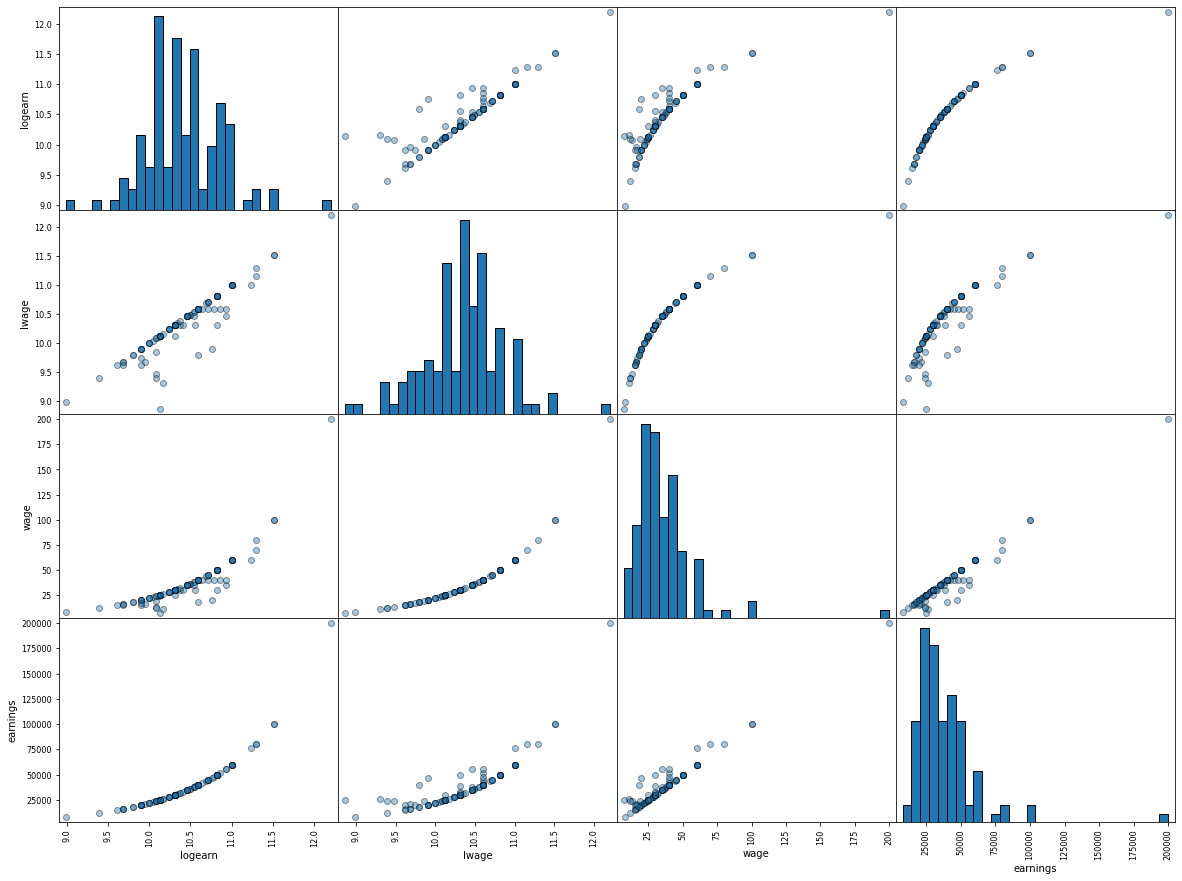

In [18]:
pd.plotting.scatter_matrix(data[['logearn', 'lwage','wage' , 'earnings']][data.wage < 200000.], 
                           alpha = 0.4, figsize = (20, 15), marker = "o",
                           hist_kwds = dict(edgecolor = "black", linewidth = 1, bins = 30),
                           edgecolor = "black")
plt.show()

In [25]:
df.columns

Index(['idind', 'yid_i', 'yredid_i', 'yid_h', 'xid_i', 'xid_h', 'wid_i',
       'wid_h', 'vid_i', 'vid_h',
       ...
       'ys1.1', 'ys1.2', 'ys2', 'ys3', 'ys4', 'ys5', 'ys6', 'ys7',
       'logearnings', 'education'],
      dtype='object', length=720)

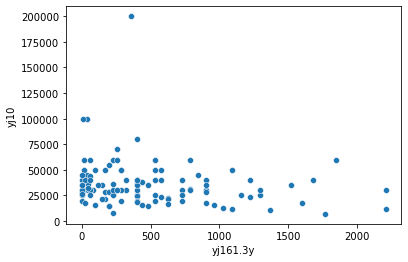

In [26]:
mask = df['yj161.3y'] < 99999996.
sns.scatterplot(x = df['yj161.3y'][mask] ** 2, y = df['yj10'][mask]);

In [27]:
df.ym1.values.max()

99999998.0

## Выбор первой модели

                            OLS Regression Results                            
Dep. Variable:                logearn   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     230.9
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           1.43e-46
Time:                        12:03:50   Log-Likelihood:                 39.964
No. Observations:                 111   AIC:                            -71.93
Df Residuals:                     107   BIC:                            -61.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1732      0.404      2.904      0.0

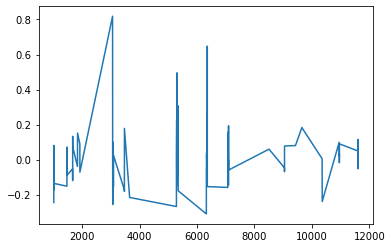

                            OLS Regression Results                            
Dep. Variable:                logearn   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     232.5
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           1.63e-51
Time:                        12:03:50   Log-Likelihood:                 54.861
No. Observations:                 111   AIC:                            -99.72
Df Residuals:                     106   BIC:                            -86.17
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0200      0.356      2.866      0.0

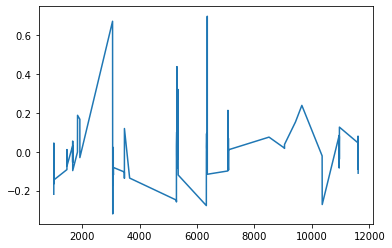

                            OLS Regression Results                            
Dep. Variable:                logearn   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     190.3
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           5.81e-51
Time:                        12:03:50   Log-Likelihood:                 56.471
No. Observations:                 111   AIC:                            -100.9
Df Residuals:                     105   BIC:                            -84.68
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0586      0.353      2.998      0.0

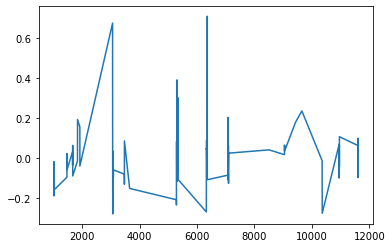

                            OLS Regression Results                            
Dep. Variable:                logearn   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     187.7
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           1.11e-50
Time:                        12:03:50   Log-Likelihood:                 55.783
No. Observations:                 111   AIC:                            -99.57
Df Residuals:                     105   BIC:                            -83.31
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0372      0.355      2.923      0.0

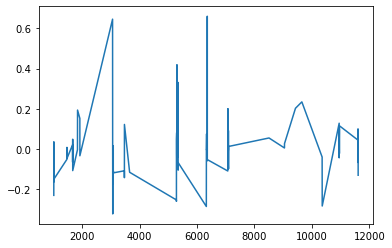

In [28]:
# factors = data[['lwage', 'female',]]
# res_exp = sm.OLS(data['logearn'], sm.add_constant(factors)).fit()
# print(res_exp.summary())
# plt.plot(res_exp.resid)
# plt.show()

#linear alternative
factors_lin_exp =  data[['exp','female', 'lwage']]
res_lin_exp = sm.OLS(data['logearn'], sm.add_constant(factors_lin_exp)).fit()
print(res_lin_exp.summary())
plt.plot(res_lin_exp.resid)
plt.show()

#base model
factors_sq_exp = data[['exp', 'exp_sq', 'female', 'lwage']]
res_sq_exp = sm.OLS(data['logearn'], sm.add_constant(factors_sq_exp)).fit()
print(res_sq_exp.summary())
plt.plot(res_sq_exp.resid)
plt.show()

#education extention
factors_ed = data[['education', 'exp', 'exp_sq', 'lwage', 'female']]
res_ed = sm.OLS(data['logearn'], sm.add_constant(factors_ed)).fit()
print(res_ed.summary())
plt.plot(res_ed.resid)
plt.show()

#workdays extention
factors_wd = data[['workdays', 'exp', 'exp_sq', 'lwage', 'female']]
res_wd = sm.OLS(data['logearn'], sm.add_constant(factors_wd)).fit()
print(res_wd.summary())
plt.plot(res_wd.resid)
plt.show()

In [29]:
data['const'] = np.ones_like(data['logearn'])

                          IV-2SLS Estimation Summary                          
Dep. Variable:                logearn   R-squared:                      0.5541
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5458
No. Observations:                 111   F-statistic:                    43.337
Date:                Thu, Dec 22 2022   P-value (F-stat)                0.0000
Time:                        12:03:52   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          7.5171     1.8997     3.9570     0.0001      3.7938      11.240
female        -0.2492     0.1031    -2.4174     0.01

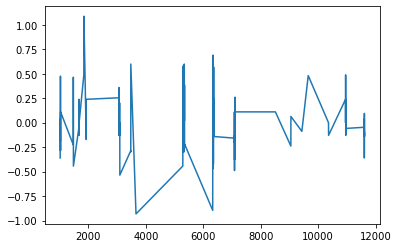

In [30]:
le_2sls_wage = IV2SLS(dependent = data['logearn'],
            exog = data[['const','female']],
            endog = data['lwage'],
            instruments = data[['exp', 'exp_sq', 'workdays']]).fit()

print(le_2sls_wage.summary)
plt.plot(le_2sls_wage.resids)
plt.show()

## Анализ остатков

# Lin Exp Model, residuals visualization

In [ ]:
# Models:
# res_lin_exp
# res_sq_exp
# res_ed
# res_wd
# le_2sls_wage

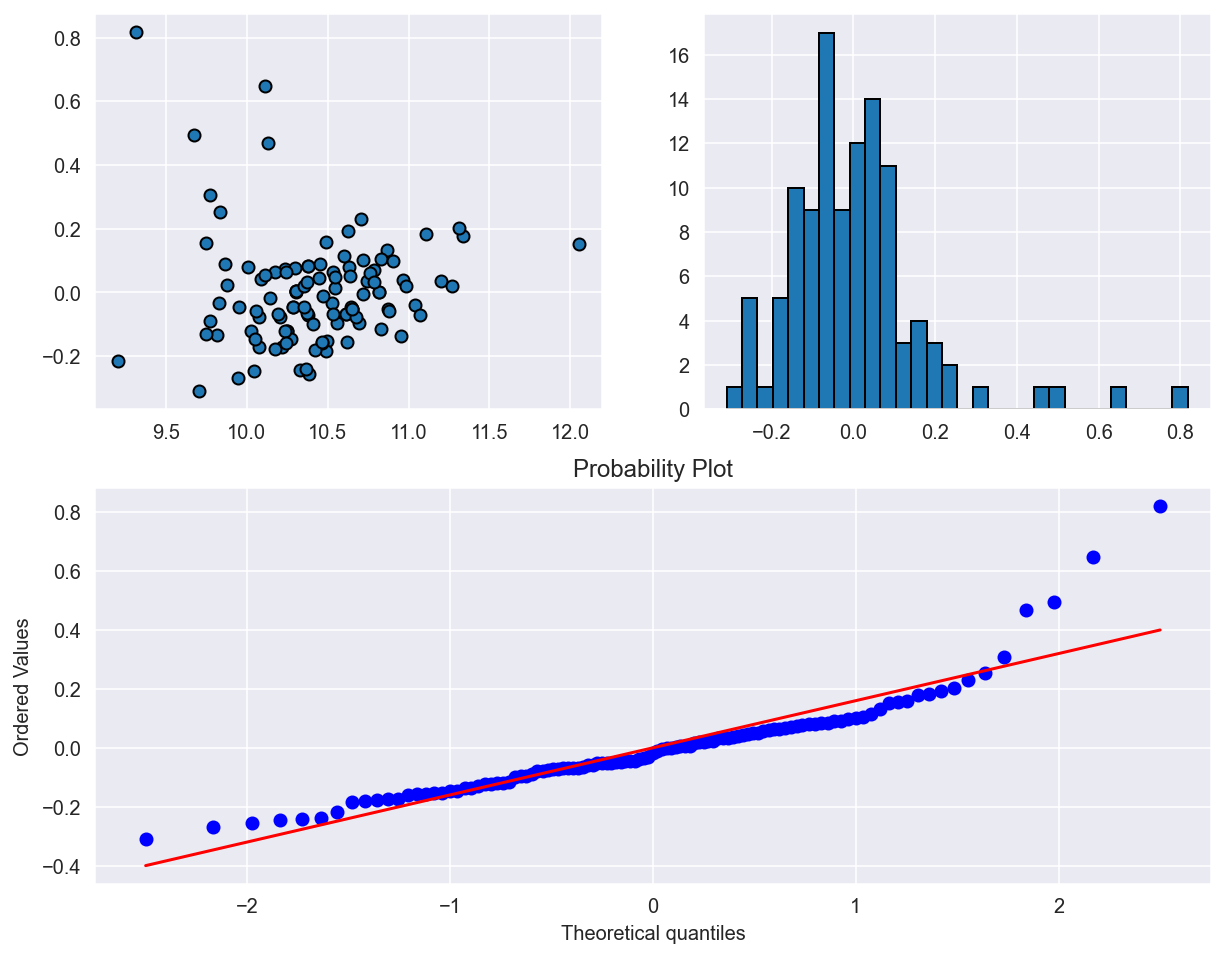

In [210]:
fig = plt.figure(num = 2, figsize = (10, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(res_lin_exp.fittedvalues, res_lin_exp.resid, linestyle = "None", marker = "o", markeredgecolor = "black")
ax = fig.add_subplot(2, 2, 2)
ax.hist(res_lin_exp.resid, bins = 30, edgecolor = "black")
ax = fig.add_subplot(2, 1, 2)
stats.probplot(res_lin_exp.resid, dist = "norm", plot = ax)

plt.show()

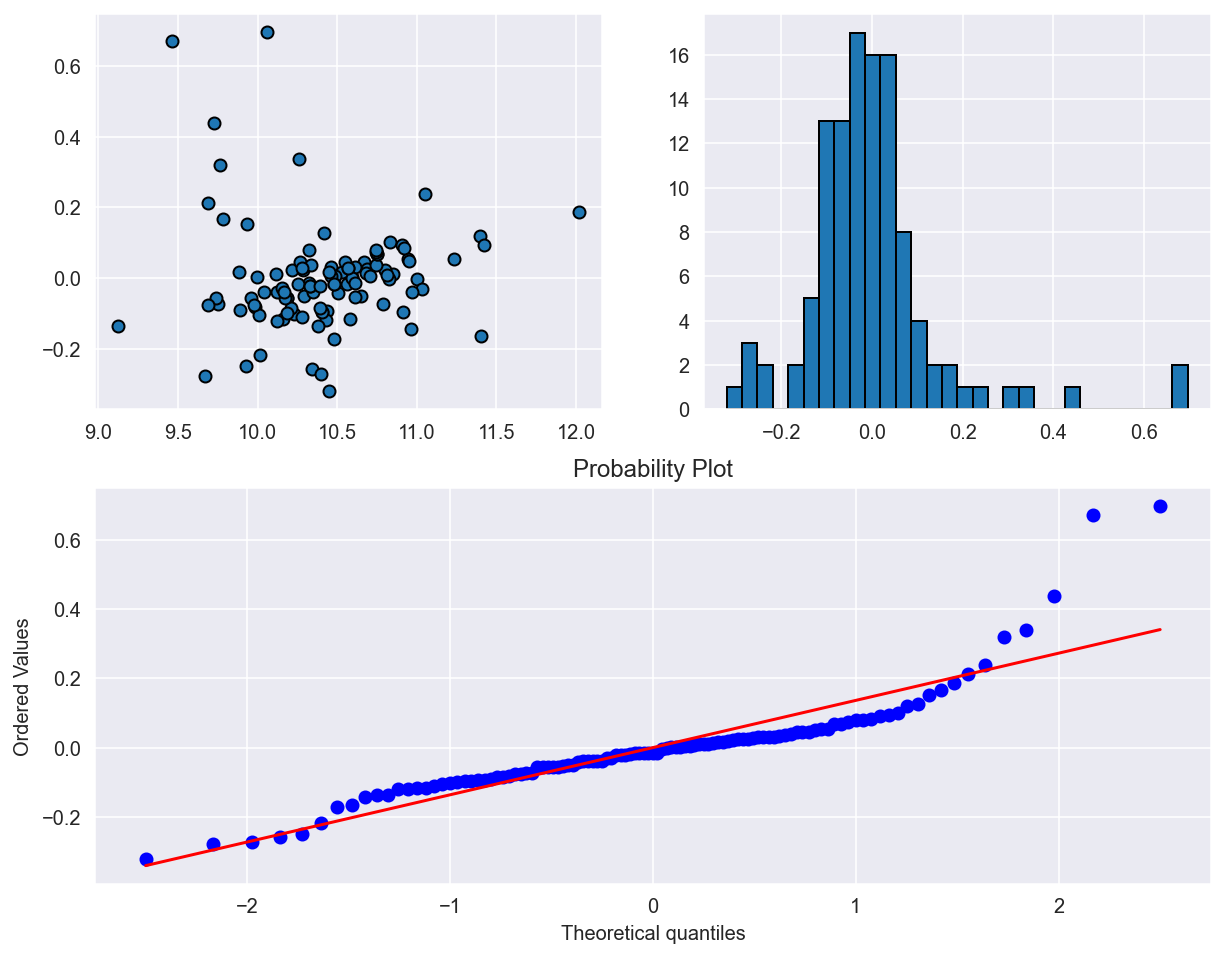

In [211]:
fig = plt.figure(num = 2, figsize = (10, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(res_sq_exp.fittedvalues, res_sq_exp.resid, linestyle = "None", marker = "o", markeredgecolor = "black")
ax = fig.add_subplot(2, 2, 2)
ax.hist(res_sq_exp.resid, bins = 30, edgecolor = "black")
ax = fig.add_subplot(2, 1, 2)
stats.probplot(res_sq_exp.resid, dist = "norm", plot = ax)

plt.show()

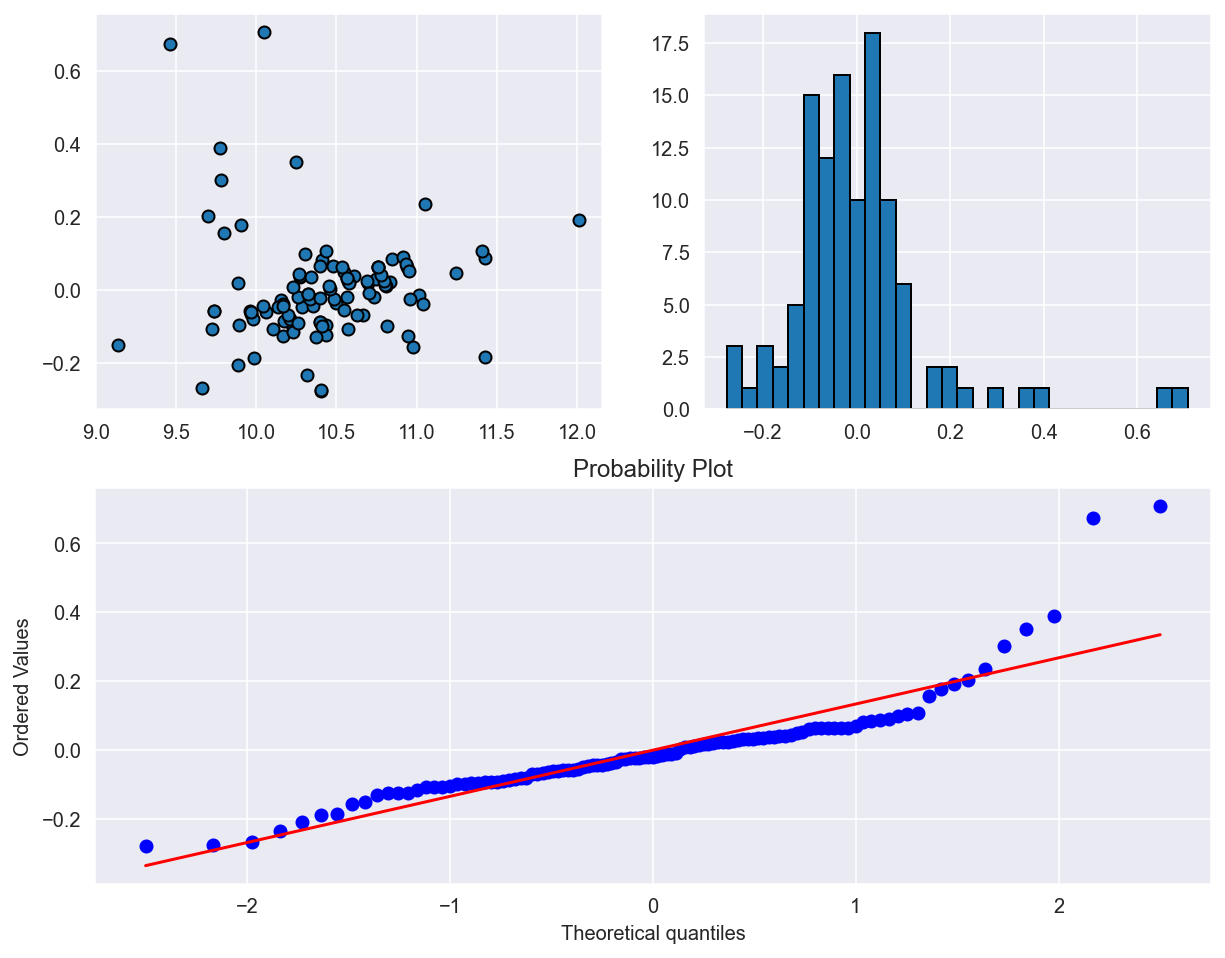

In [212]:
fig = plt.figure(num = 2, figsize = (10, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(res_ed.fittedvalues, res_ed.resid, linestyle = "None", marker = "o", markeredgecolor = "black")
ax = fig.add_subplot(2, 2, 2)
ax.hist(res_ed.resid, bins = 30, edgecolor = "black")
ax = fig.add_subplot(2, 1, 2)
stats.probplot(res_ed.resid, dist = "norm", plot = ax)

plt.show()

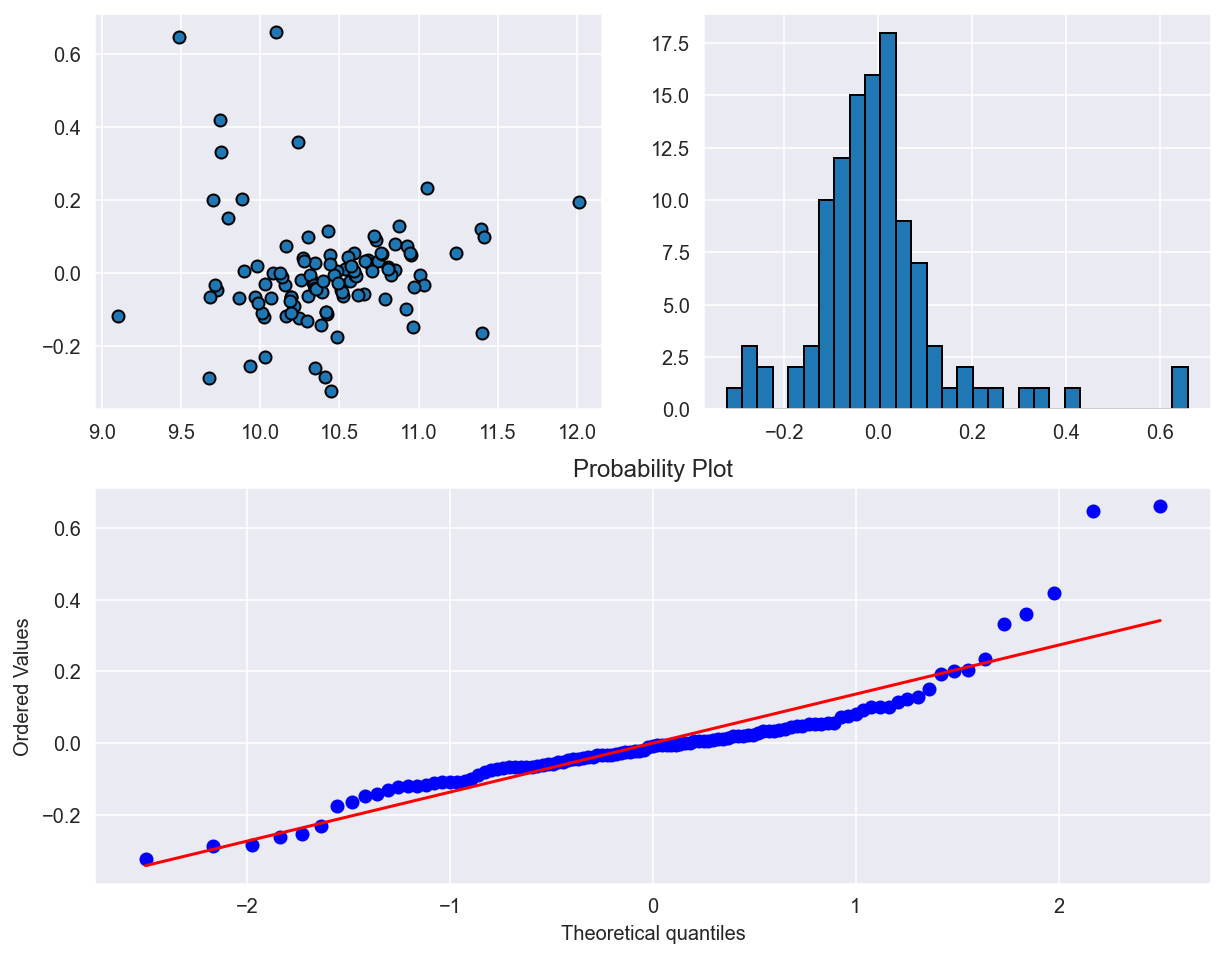

In [213]:
fig = plt.figure(num = 2, figsize = (10, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(res_wd.fittedvalues, res_wd.resid, linestyle = "None", marker = "o", markeredgecolor = "black")
ax = fig.add_subplot(2, 2, 2)
ax.hist(res_wd.resid, bins = 30, edgecolor = "black")
ax = fig.add_subplot(2, 1, 2)
stats.probplot(res_wd.resid, dist = "norm", plot = ax)

plt.show()

In [214]:
le_2sls_wage.fitted_values

,fitted_values
1014,10.159070
1016,10.678606
1020,10.231397
1024,10.763491
1026,10.379547
...,...
11603,10.558967
11604,10.309797
11605,10.643852
11608,10.604452


## 2SLS Модель

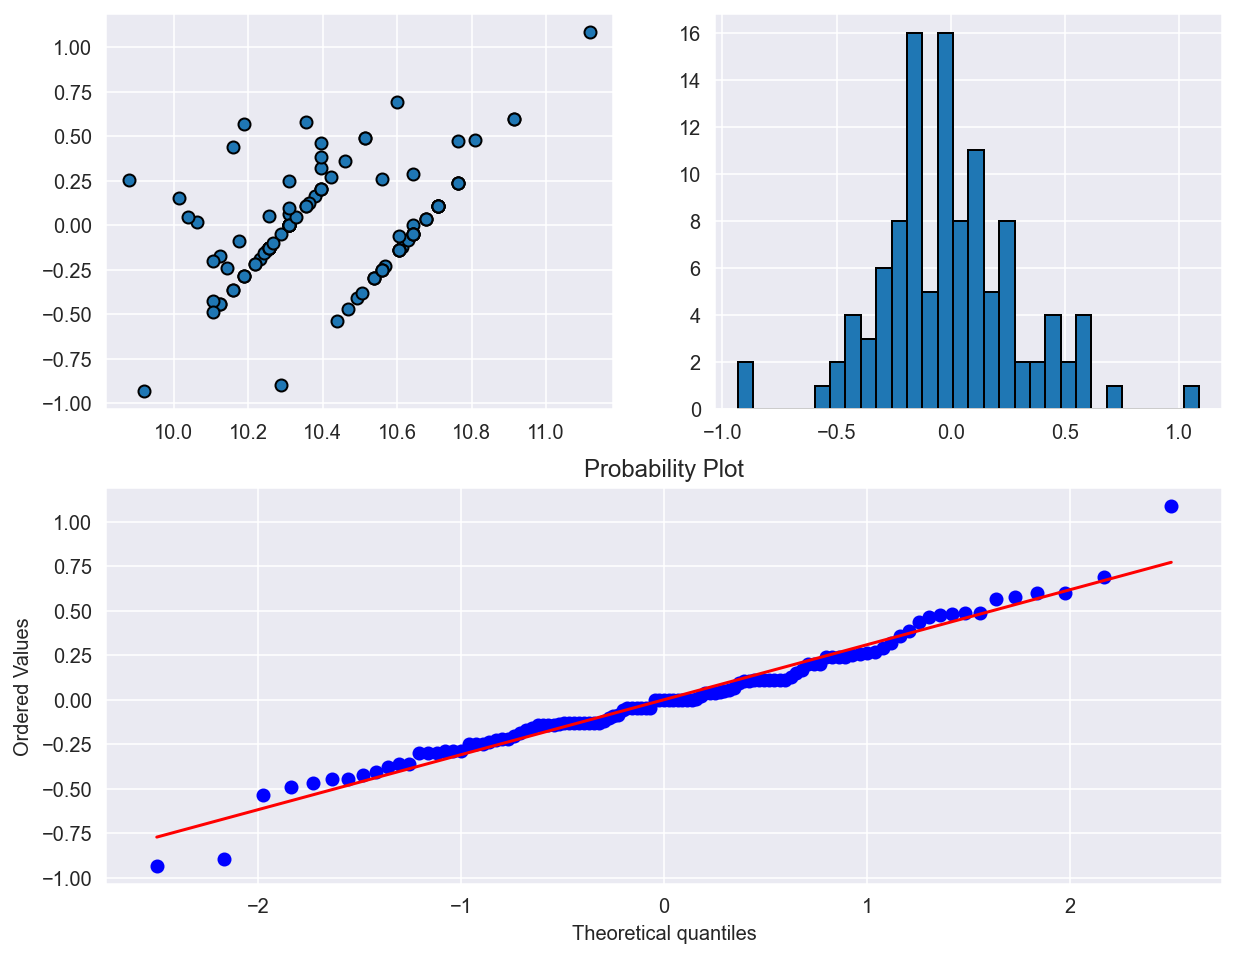

In [215]:
fig = plt.figure(num = 2, figsize = (10, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(le_2sls_wage.fitted_values.values, le_2sls_wage.resids, linestyle = "None", marker = "o", markeredgecolor = "black")
ax = fig.add_subplot(2, 2, 2)
ax.hist(le_2sls_wage.resids, bins = 30, edgecolor = "black")
ax = fig.add_subplot(2, 1, 2)
stats.probplot(le_2sls_wage.resids, dist = "norm", plot = ax)

plt.show()

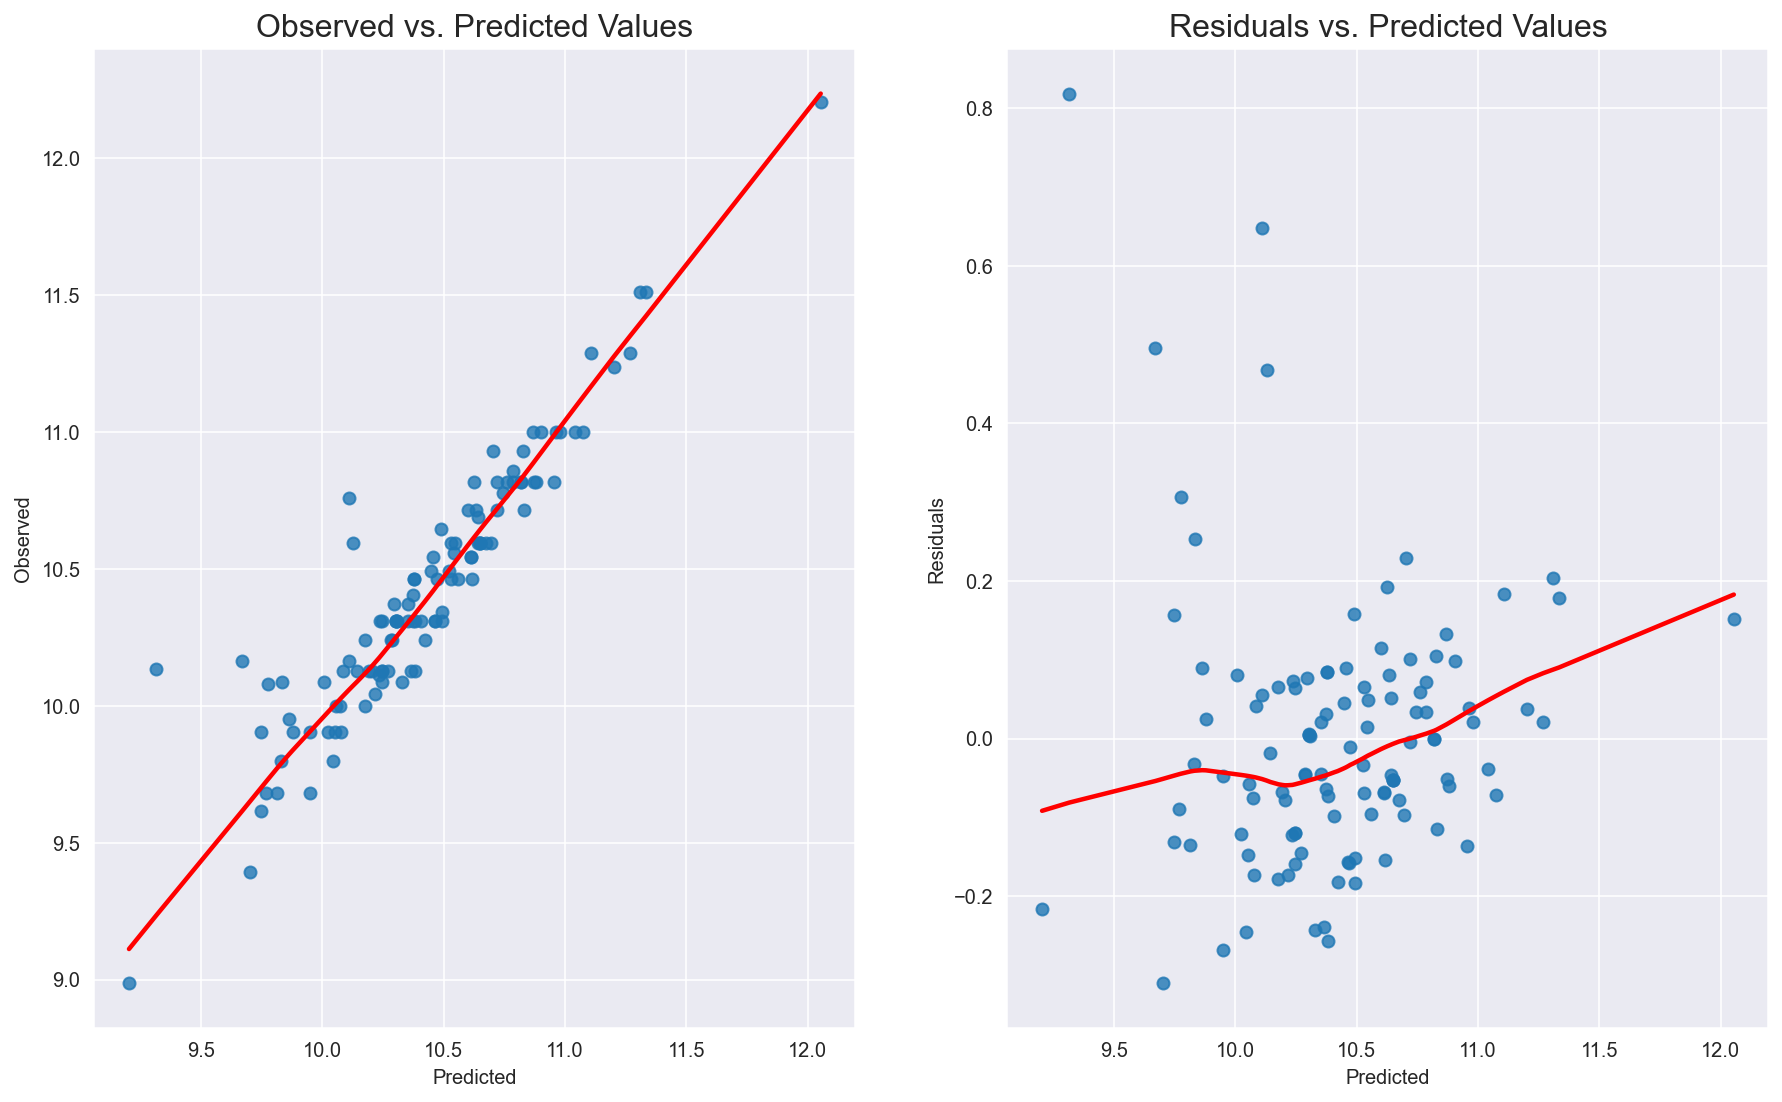

In [216]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(res_lin_exp, data.logearn)  

## Значимость коэффициентов в квадратичной модели

In [31]:
hypotheses = 'exp = exp_sq = 0'

f_test = res_wd.f_test(hypotheses)
print(f_test)

<F test: F=36.74050264421639, p=8.014160226193202e-13, df_denom=105, df_num=2>


## Условное математическое ожидание остатков равно нулю

In [217]:
print('Linear experience model: ',np.mean(res_lin_exp.resid),'\n--------------------------------------------------')
print('Squared experience model: ',np.mean(res_sq_exp.resid),'\n--------------------------------------------------')
print('Squared experience model with education feature: ',np.mean(res_ed.resid),'\n--------------------------------------------------')
print('Squared experience model with workday feature: ',np.mean(res_wd.resid),'\n--------------------------------------------------')
print('Squared experience model with endogeneous wage feature: ',np.mean(le_2sls_wage.resids),'\n--------------------------------------------------')

Linear experience model:  -1.4546922225358808e-14 
--------------------------------------------------
Squared experience model:  -1.86117387767792e-14 
--------------------------------------------------
Squared experience model with education feature:  9.44189671392926e-16 
--------------------------------------------------
Squared experience model with workday feature:  6.725991135419201e-13 
--------------------------------------------------
Squared experience model with endogeneous wage feature:  1.6316493701696845e-11 
--------------------------------------------------


## Тест Бройша-Пагана, Тест Уайта, Тест Дарбина Уотсона на Гетероскедастичность

In [218]:
# H0: гомоскедастичность
name = ['LM statistic', 'LM p-value', 'F-value', 'F  p-value']
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

bp_test = sm_diagnostic.het_breuschpagan(resid = res_lin_exp.resid, exog_het = factors_lin_exp)
du_test = durbin_watson(res_lin_exp.resid)
white_test = sm_diagnostic.het_white(res_lin_exp.resid,  exog = res_lin_exp.model.exog)
print('Linear experience model\n')
print('Durbin Watson test: ',du_test,'\n')
print('White test:\n\n', pd.DataFrame([np.round(white_test, 3)], columns=labels))
print('BP test:\n\n',pd.DataFrame([np.round(bp_test, 3)], columns=name),'\n--------------------------------------------------\n')

bp_test = sm_diagnostic.het_breuschpagan(resid = res_sq_exp.resid, exog_het = factors_sq_exp)
du_test = durbin_watson(res_sq_exp.resid)
white_test = sm_diagnostic.het_white(res_sq_exp.resid,  exog = res_lin_exp.model.exog)
print('Squared experience model\n')
print('Durbin Watson test: ',du_test,'\n')
print('White test:\n\n', pd.DataFrame([np.round(white_test, 3)], columns=labels))
print('BP test:\n\n',pd.DataFrame([np.round(bp_test, 3)], columns=name),'\n--------------------------------------------------\n')

bp_test = sm_diagnostic.het_breuschpagan(resid = res_ed.resid, exog_het = factors_ed)
du_test = durbin_watson(res_ed.resid)
white_test = sm_diagnostic.het_white(res_ed.resid,  exog = res_ed.model.exog)
print('Squared experience model with education feature\n')
print('Durbin Watson test: ',du_test,'\n')
print('White test:\n\n', pd.DataFrame([np.round(white_test, 3)], columns=labels))
print('BP test:\n\n',pd.DataFrame([np.round(bp_test, 3)], columns=name),'\n--------------------------------------------------\n')

bp_test = sm_diagnostic.het_breuschpagan(resid = res_lin_exp.resid, exog_het = factors_wd)
du_test = durbin_watson(res_lin_exp.resid)
white_test = sm_diagnostic.het_white(res_lin_exp.resid,  exog = res_lin_exp.model.exog)
print('Squared experience model with workdays feature\n')
print('Durbin Watson test: ',du_test,'\n')
print('White test:\n\n', pd.DataFrame([np.round(white_test, 3)], columns=labels))
print('BP test:\n\n',pd.DataFrame([np.round(bp_test, 3)], columns=name),'\n--------------------------------------------------\n')

Linear experience model

Durbin Watson test:  2.0082783890464624 

White test:

    Test Statistic  Test Statistic p-value  F-Statistic  F-Test p-value
0          61.998                     0.0       16.132             0.0
BP test:

    LM statistic  LM p-value  F-value  F  p-value
0        28.678         0.0   12.541         0.0 
--------------------------------------------------

Squared experience model

Durbin Watson test:  1.8706507143884408 

White test:

    Test Statistic  Test Statistic p-value  F-Statistic  F-Test p-value
0          42.753                     0.0        7.987             0.0
BP test:

    LM statistic  LM p-value  F-value  F  p-value
0        25.767         0.0    8.087         0.0 
--------------------------------------------------

Squared experience model with education feature

Durbin Watson test:  1.9346211643263307 

White test:

    Test Statistic  Test Statistic p-value  F-Statistic  F-Test p-value
0          47.308                     0.0        3.79

### Тесты Дарбина-Уотона и Бройша-Годфри на наличие корреляций в ошибках не проводится, так как нет оснований предполагать, наличие автокорреляции в модели

In [ ]:
# print(sm_tools.durbin_watson(res_no_exp.resid))

## Тесты на нормальность остатоков

In [219]:
# H0: нормальность остатков 
norm_tests = ["Anderson-Darling", 
              "Kolmogorov-Smirnov", 
              "Jarque-Bera"]

norm_test = pd.DataFrame()
norm_test["p_value"] = [
    sm_diagnostic.normal_ad(x = res_lin_exp.resid)[1],
    sm_diagnostic.kstest_normal(x = res_lin_exp.resid, dist = "norm")[1],
    sm_tools.jarque_bera(res_lin_exp.resid)[1]
]
norm_test["Test"] = norm_tests

print('Linear experience model:\n\n',norm_test,'\n-------------------------------')

norm_tests = ["Anderson-Darling", 
              "Kolmogorov-Smirnov", 
              "Jarque-Bera"]

norm_test = pd.DataFrame()
norm_test["p_value"] = [
    sm_diagnostic.normal_ad(x = res_sq_exp.resid)[1],
    sm_diagnostic.kstest_normal(x = res_sq_exp.resid, dist = "norm")[1],
    sm_tools.jarque_bera(res_sq_exp.resid)[1]
]
norm_test["Test"] = norm_tests

print('Squared experience model:\n\n',norm_test,'\n-------------------------------')

norm_tests = ["Anderson-Darling", 
              "Kolmogorov-Smirnov", 
              "Jarque-Bera"]

norm_test = pd.DataFrame()
norm_test["p_value"] = [
    sm_diagnostic.normal_ad(x = res_ed.resid)[1],
    sm_diagnostic.kstest_normal(x = res_ed.resid, dist = "norm")[1],
    sm_tools.jarque_bera(res_ed.resid)[1]
]
norm_test["Test"] = norm_tests

print('Squared experience model with education feature:\n\n',norm_test,'\n-------------------------------')

norm_tests = ["Anderson-Darling", 
              "Kolmogorov-Smirnov", 
              "Jarque-Bera"]

norm_test = pd.DataFrame()
norm_test["p_value"] = [
    sm_diagnostic.normal_ad(x = res_wd.resid)[1],
    sm_diagnostic.kstest_normal(x = res_wd.resid, dist = "norm")[1],
    sm_tools.jarque_bera(res_wd.resid)[1]
]
norm_test["Test"] = norm_tests

print('Squared experience model with workday feature:\n\n',norm_test,'\n-------------------------------')

Linear experience model:

         p_value                Test
0  1.394498e-06    Anderson-Darling
1  1.000000e-03  Kolmogorov-Smirnov
2  2.685199e-48         Jarque-Bera 
-------------------------------
Squared experience model:

         p_value                Test
0  2.902647e-11    Anderson-Darling
1  1.000000e-03  Kolmogorov-Smirnov
2  1.496962e-69         Jarque-Bera 
-------------------------------
Squared experience model with education feature:

         p_value                Test
0  2.674632e-10    Anderson-Darling
1  1.000000e-03  Kolmogorov-Smirnov
2  2.696185e-80         Jarque-Bera 
-------------------------------
Squared experience model with workday feature:

         p_value                Test
0  1.003217e-10    Anderson-Darling
1  1.000000e-03  Kolmogorov-Smirnov
2  4.386782e-52         Jarque-Bera 
-------------------------------


## Тест мультиколлинеарности (Variance inflation factor)

In [32]:
print('VIF tests (< 10)')
factors_sh = factors_lin_exp
display(pd.Series([vif(factors_sh.values, i) for i in range(factors_sh.shape[1])], index=factors_sh.columns, name = 'Linear experience model'))
factors_sh = factors_sq_exp
display(pd.Series([vif(factors_sh.values, i) for i in range(factors_sh.shape[1])], index=factors_sh.columns, name = 'Linear experience model with education feature'))
factors_sh = factors_ed
display(pd.Series([vif(factors_sh.values, i) for i in range(factors_sh.shape[1])], index=factors_sh.columns, name = 'Linear experience model with education and workdays features'))
factors_sh = factors_wd
display(pd.Series([vif(factors_sh.values, i) for i in range(factors_sh.shape[1])], index=factors_sh.columns, name = 'Squared experience model with workdays and education feature'))

VIF tests (< 10)


exp       3.726041
female    2.340056
lwage     4.424654
Name: Linear experience model, dtype: float64

exp       40.688874
exp_sq    21.366573
female     2.388980
lwage      7.656280
Name: Linear experience model with education feature, dtype: float64

education     5.023307
exp          40.705152
exp_sq       21.515696
lwage        11.913399
female        2.403379
Name: Linear experience model with education and workdays features, dtype: float64

workdays    20.142346
exp         40.690001
exp_sq      21.390280
lwage       25.696304
female       2.393097
Name: Squared experience model with workdays and education feature, dtype: float64

##  Тест на схожесть поведения регрессии на подвыборках (Rainbow test)

Для модели с линейным стажем

In [221]:
# H0: sample and central subset are identical(the fit of the model using full sample is the same as using a central subset)
print('Linear experience model:\n')
data_rain = data.iloc[np.argsort(data["lwage"]), :]
factors_rain = data_rain[['exp','female','lwage']]

print('Non linearity in wages\n')

logearn_rain = data_rain['logearn']
res_rain = sm.OLS(logearn_rain, factors_rain).fit()
rain_t1 = sm_diagnostic.linear_rainbow(res_rain)
print(pd.DataFrame(rain_t1, index = ["F-stat", "p-value"]).T,'\n---------------------------\n')

print('Non linearity in experience\n')

data_rain = data.iloc[np.argsort(data["exp"]), :]
factors_rain = data_rain[['exp','female','wage']]

logearn_rain = data_rain['logearn']
res_rain = sm.OLS(logearn_rain, factors_rain).fit()
rain_t1 = sm_diagnostic.linear_rainbow(res_rain)
print(pd.DataFrame(rain_t1, index = ["F-stat", "p-value"]).T,'\n---------------------------\n')

Linear experience model:

Non linearity in wages

     F-stat       p-value
0  6.045708  4.135895e-10 
---------------------------

Non linearity in experience

     F-stat   p-value
0  3.146122  0.000025 
---------------------------



## Вывод: модель сильно страдает от гетероскедастичности. Также из-за того, что итоговая выборка маленькая, нельзя однозначно оценить разницу в суммарных заработках в зависимости от заработной платы, пола и других фич(так как достаточно часто встречаются кейсы, когда респондент зарабатывает ровно столько, сколько получает на работе.)